In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import itertools

import seaborn as sns

### Data

In [29]:
df = pd.read_csv('data/tetragonal.csv')
df = df[df.Zr > 0]

tetragonal = pd.read_csv('data/tetragonal.csv')
tetragonal = tetragonal[tetragonal.Zr > 0]

monoclinic = pd.read_csv('data/monoclinic.csv')
monoclinic = monoclinic[monoclinic.Zr > 0]

In [6]:
inputs = ['T']
features = ['en_p', 'ea', 'valence', 'pettifor', 'rad_ionic', 'rad_slater', 'rad_clementi']
# outputs = ['a', 'c']
outputs = ['a']

### ML

In [7]:
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [8]:
reg  = BayesianRidge(compute_score=True)

In [9]:
X = df[inputs + features].values
y = df[outputs].values.reshape(-1)

In [10]:
Xr, Xt, yr, yt = train_test_split(X, y, test_size=0.3)

In [11]:
reg.fit(Xr, yr)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [40]:
def get_stats(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rsq, _ = stats.pearsonr(y_true, y_pred)
    
    return rmse, rsq
    
def plot_train_test(reg, Xr, Xt, yr, yt, unit='Å', figtitle=''):
    fig, ax_fig = plt.subplots(1, 2, figsize=(8, 4))

    for idx, (title, color, x_plot, y_plot) in enumerate(zip(
        ['train', 'test'],
        ['#1f77b4', '#ff7f0e'],
        [Xr, Xt],
        [yr, yt]
    )):
        ax = ax_fig[idx]

        y_pred = reg.predict(x_plot)
        ax.scatter(y_plot, y_pred, alpha=0.6, c=color)

        rmse, rsq = get_stats(y_plot, y_pred)

        lim_min = min(np.min(y_plot), np.min(y_plot))
        lim_max = max(np.max(y_plot), np.max(y_plot))
        lims = (lim_min, lim_max)

        ax.plot(lims, lims, 'k', zorder=-1)

        ax.annotate(
            'RMSE = %.2e %s\nR$^2$ = %.2f' % (rmse, unit, rsq),
            (0.05, 0.96),
            xycoords='axes fraction',
            va='top',
            fontsize=12
        )

        ax.set_xlabel(f'True lattice parameter ({unit})', fontsize=12)

        if idx == 0:
            ax.set_ylabel(f'Predicted lattice parameter ({unit})', fontsize=12)

        ax.set_title(title)

        ax.set_xlim(lims)
        ax.set_ylim(lims)
    
    fig.suptitle(figtitle)
    plt.show()

### Plotting with all features:

In [41]:
inputs = ['T']
features = ['en_p', 'ea', 'valence', 'pettifor', 'rad_ionic', 'rad_slater', 'rad_clementi']
outputs = ['a', 'c']

def get_model(features, output, df):
    X = df[inputs + features].values
    y = df[output].values.reshape(-1)
    Xr, Xt, yr, yt = train_test_split(X, y, test_size=0.3)
    
    reg  = BayesianRidge(compute_score=True)
    reg.fit(Xr, yr)
    
    return reg, Xr, Xt, yr, yt

In [48]:
outputs_tetragonal = ['a', 'c']
outputs_monoclinic = ['a', 'b', 'c', 'beta']

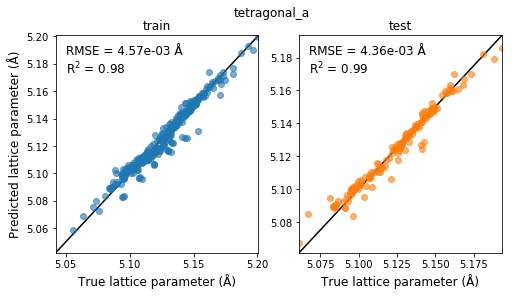

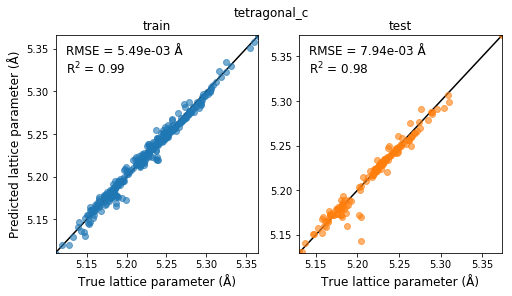

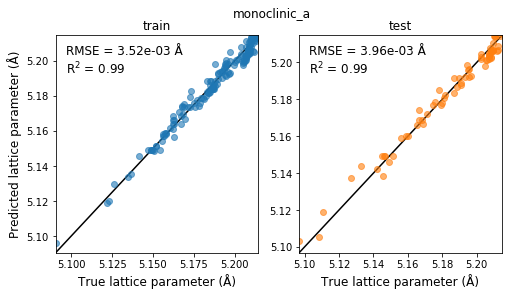

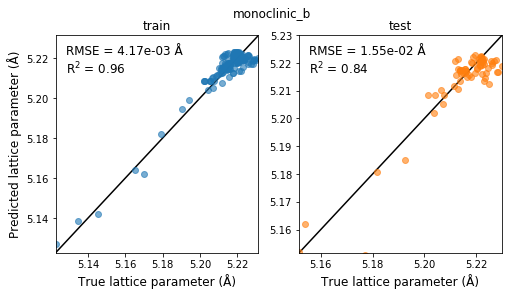

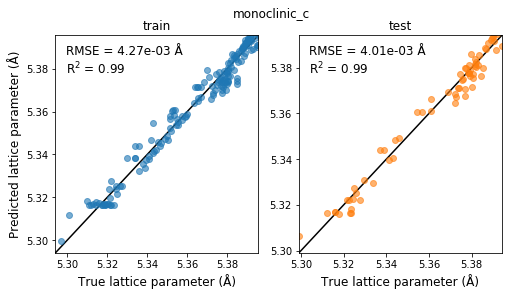

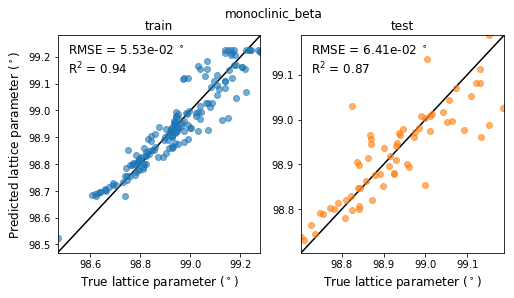

In [49]:
for df, lattice, outputs in zip(
    [tetragonal, monoclinic],
    ['tetragonal', 'monoclinic'],
    [outputs_tetragonal, outputs_monoclinic],
):
    for output in outputs:
        reg, Xr, Xt, yr, yt = get_model(features, output, df)
        unit = '$^\circ$' if output == 'beta' else 'Å'
        name = '%s_%s' % (lattice, output)
        
        plot_train_test(reg, Xr, Xt, yr, yt, unit=unit, figtitle=name)

### Summarizing this information

In [50]:
summary = pd.DataFrame(
    columns=['parameter', 'rmse', 'rsq']
)

In [53]:
NRUNS = 50
for _ in range(NRUNS):
    for df, lattice, outputs in zip(
        [tetragonal, monoclinic],
        ['tetragonal', 'monoclinic'],
        [outputs_tetragonal, outputs_monoclinic],
    ):
        for output in outputs:
            reg, Xr, Xt, yr, yt = get_model(features, output, df)
            
            rmse, rsq = get_stats(yt, reg.predict(Xt))

            summary = summary.append({
                'parameter': '%s_%s' % (lattice, output),
                'rmse': rmse,
                'rsq': rsq
            }, ignore_index=True)

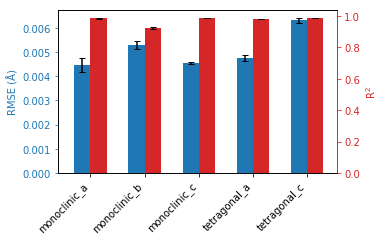

In [124]:
fig, ax = plt.subplots(figsize=(5, 3))
means = summary.groupby('parameter').mean().drop('monoclinic_beta')
errors = summary.groupby('parameter').std().drop('monoclinic_beta') / np.sqrt(NRUNS)

width=0.3
cax = '#1f77b4'
ctax = '#d62728'

p1 = means['rmse'].plot.bar(
    yerr=errors['rmse'],
    capsize=3,
    ax=ax,
    position=1,
    width=width,
    color=cax
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel('')
ax.set_ylabel('RMSE (Å)')

tax = ax.twinx()
p2 = means['rsq'].plot.bar(
    yerr=errors['rsq'],
    capsize=3,
    ax=tax,
    position=0,
    width=width,
    color=ctax
)
tax.set_ylabel('R$^2$')

ax.set_xlim(left=-0.6)

for ax_, color in zip([ax, tax], [cax, ctax]):
    ax_.yaxis.label.set_color(color)
    ax_.spines["right"].set_edgecolor(color)
    ax_.tick_params(axis='y', colors=color)

plt.show()

In [122]:
summary.groupby('parameter').mean()

,rmse,rsq
parameter,,
monoclinic_a,0.004446,0.984586
monoclinic_b,0.005299,0.925814
monoclinic_beta,0.062346,0.919197
monoclinic_c,0.004553,0.985933
tetragonal_a,0.004764,0.981374
tetragonal_c,0.006312,0.989013
